## Feature Engineering

This notebook focuses on processing the data and doing feature engineering.

At the end, this notebook will output the full dataset with all features included.

In [1]:
# Import the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import seaborn as sns

from datetime import datetime

from statsmodels.tsa.stattools import ccf

# Set all columns and rows to be displayed
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

/usr/local/Caskroom/miniconda/base/envs/dsi-sg/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/usr/local/Caskroom/miniconda/base/envs/dsi-sg/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


### Import Data

In [2]:
# Import the dataset
data = pd.read_csv("../datasets/merged_df2.csv")

In [3]:
# Check the data
data.head()

,time,dengue_cases,denv_1,denv_2,denv_3,denv_4,Mean Temperature (°C),Mean Wind Speed (km/h),Daily Rainfall Total (mm),Maximum Temperature (°C),Max Wind Speed (km/h),Minimum Temperature (°C),google_trends
0,2018-04-08,38,0.000,0.505,0.484,0.011,28.528571,10.714286,0.742857,33.8,36.7,25.5,20
1,2018-04-15,56,0.000,0.505,0.484,0.011,28.914286,9.828571,2.057143,34.4,38.2,24.6,18
2,2018-04-22,55,0.000,0.505,0.484,0.011,28.142857,7.700000,0.371429,34.3,37.1,25.5,21
3,2018-04-29,74,0.000,0.505,0.484,0.011,28.414286,6.842857,4.800000,35.0,43.6,22.6,23
4,2018-05-06,62,0.029,0.549,0.382,0.039,28.785714,8.328571,3.742857,34.2,44.6,23.6,39


No catagorical values observed. However, due to the different types of numerical values being used, scaling will be required.

In [4]:
# Check the shape of the data
data.shape

(257, 13)

In [5]:
# Look at the datatypes
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 257 entries, 0 to 256
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   time                       257 non-null    object 
 1   dengue_cases               257 non-null    int64  
 2   denv_1                     257 non-null    float64
 3   denv_2                     257 non-null    float64
 4   denv_3                     257 non-null    float64
 5   denv_4                     257 non-null    float64
 6   Mean Temperature (°C)      257 non-null    float64
 7   Mean Wind Speed (km/h)     257 non-null    float64
 8   Daily Rainfall Total (mm)  257 non-null    float64
 9   Maximum Temperature (°C)   257 non-null    float64
 10  Max Wind Speed (km/h)      257 non-null    float64
 11  Minimum Temperature (°C)   257 non-null    float64
 12  google_trends              257 non-null    int64  
dtypes: float64(10), int64(2), object(1)
memory usage: 

### Date Processing

The date feature is currently an object time. We will be converting it into a dateTime format.

In [6]:
# Convert the date column into dateTime format
data['time'] = pd.to_datetime(data['time'])

In [7]:
# Set the time as the index
data = data.set_index('time')

In [8]:
# Check the data 
data.head()

,dengue_cases,denv_1,denv_2,denv_3,denv_4,Mean Temperature (°C),Mean Wind Speed (km/h),Daily Rainfall Total (mm),Maximum Temperature (°C),Max Wind Speed (km/h),Minimum Temperature (°C),google_trends
time,,,,,,,,,,,,
2018-04-08,38,0.000,0.505,0.484,0.011,28.528571,10.714286,0.742857,33.8,36.7,25.5,20
2018-04-15,56,0.000,0.505,0.484,0.011,28.914286,9.828571,2.057143,34.4,38.2,24.6,18
2018-04-22,55,0.000,0.505,0.484,0.011,28.142857,7.700000,0.371429,34.3,37.1,25.5,21
2018-04-29,74,0.000,0.505,0.484,0.011,28.414286,6.842857,4.800000,35.0,43.6,22.6,23
2018-05-06,62,0.029,0.549,0.382,0.039,28.785714,8.328571,3.742857,34.2,44.6,23.6,39


### Feature Engineering

#### Cross Correlation between predictor variables and dengue cases

In [9]:
# function to plot ccf
def plot_ccf(x, y, lags=None, ax=None):
    
    ccf_output = ccf(x[::-1], y[::-1], adjusted=False)
    
    #plt.stem(range(-len(ccf_output)//2, len(ccf_output)//2), ccf_output)
    if ax==None:
        plt.stem(range(len(ccf_output)), ccf_output)

        if lags == None:
            pass
        else:
            plt.xlim([0,lags])

        plt.ylim([-1,1])
        plt.xlabel('Lag')
        plt.ylabel('CCF')
        # 95% UCL / LCL
        plt.axhline(-1.96/np.sqrt(len(x)), color='k', ls='--') 
        plt.axhline(1.96/np.sqrt(len(x)), color='k', ls='--')

        plt.show()
    
    else:
        ax.stem(range(len(ccf_output)), ccf_output)

        if lags == None:
            pass
        else:
            ax.set_xlim([0,lags])

        ax.set_ylim([-1,1])
        ax.set_xlabel('Lag')
        ax.set_ylabel('CCF')
        # 95% UCL / LCL
        ax.axhline(-1.96/np.sqrt(len(x)), color='k', ls='--') 
        ax.axhline(1.96/np.sqrt(len(x)), color='k', ls='--')

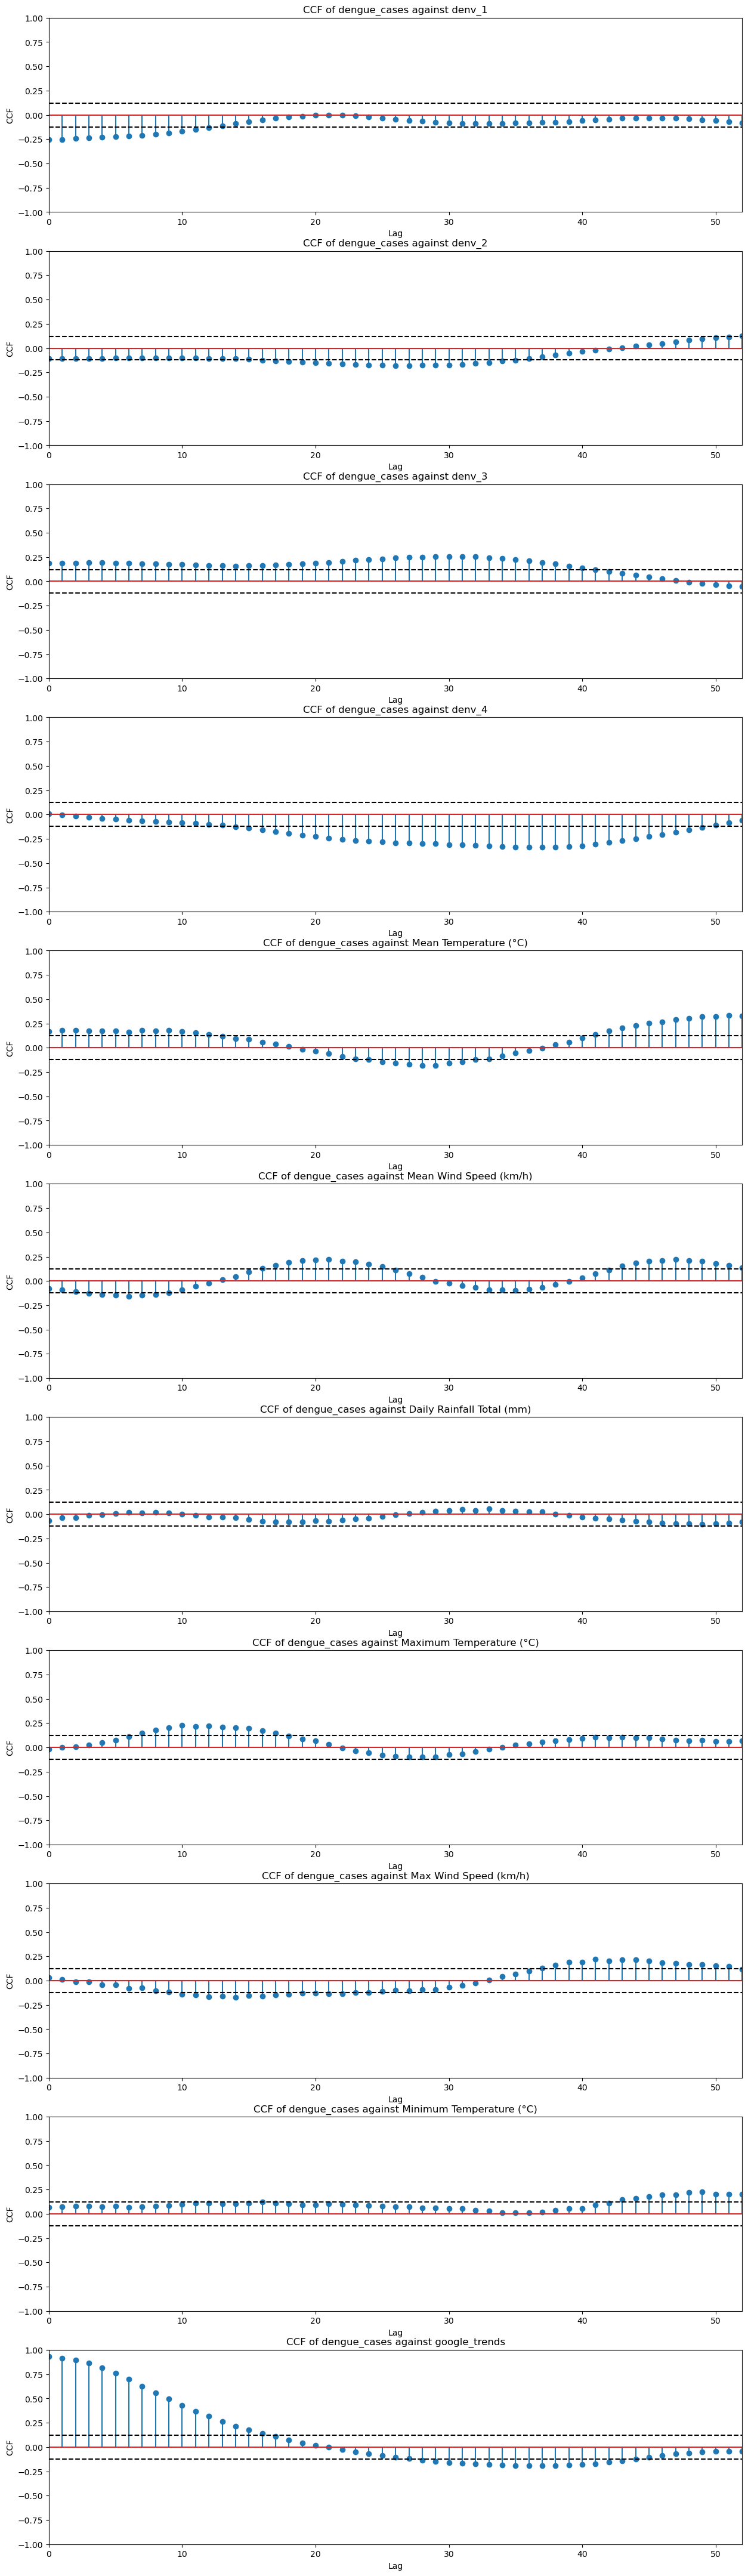

In [10]:
# Generate cross correlation between predictor variables and dengue cases
# do a plot for each of the variables
n_plots = len(data.columns)-1

fig, axes = plt.subplots(nrows=n_plots, figsize=(15,5*n_plots))

for i, x in enumerate(data.drop(columns='dengue_cases')):
    axes[i].set_title(f'CCF of dengue_cases against {x}')
    plot_ccf(data[x], data['dengue_cases'], lags=52, ax=axes[i])

**Lagging of Features**
1. Serotypes: These will not be lagged as they are directly proportionate to the current number of cases
2. Mean Temperature: Significance seen on lags 0, 28, and 51. 
3. Mean Wind Speed: Significance seen on lags 6, 22, 47
4. Daily Rainfall Total: No significance observed in the lags
5. Max Temperature: Significance seen at lag 10
6. Max Wind Speed: Significance seen at lags 14 and 41
7. Minimum Temperature: Significance seen at lag 49
8. Google Trends: Strong significance seen at lags 0 and 1. No need to introduce lag

In [11]:
# Lag Mean Temperature
data['Mean Temperature (°C)_lag28'] = data['Mean Temperature (°C)'].shift(28)
data['Mean Temperature (°C)_lag51'] = data['Mean Temperature (°C)'].shift(51)

# Lag Mean Wind Speed
data['Mean Wind Speed (km/h)_lag6'] = data['Mean Wind Speed (km/h)'].shift(6)
data['Mean Wind Speed (km/h)_lag22'] = data['Mean Wind Speed (km/h)'].shift(22)
data['Mean Wind Speed (km/h)_lag47'] = data['Mean Wind Speed (km/h)'].shift(47)

# Lag Maximum Temperature
data['Maximum Temperature (°C)_lag10'] = data['Maximum Temperature (°C)'].shift(10)

# Max Wind Speed
data['Max Wind Speed (km/h)_lag14'] = data['Max Wind Speed (km/h)'].shift(14)
data['Max Wind Speed (km/h)_lag41'] = data['Max Wind Speed (km/h)'].shift(41)

# Minimum Temperature
data['Minimum Temperature (°C)_lag49'] = data['Minimum Temperature (°C)'].shift(49)

#### Dengue Cases Lags

Apart from the lags of the exogenous features, we will laso create lags for the dengue cases, from 1 to 3 weeks.

In [12]:
data['dengue_cases_lag_1'] = data['dengue_cases'].shift(1)
data['dengue_cases_lag_2'] = data['dengue_cases'].shift(2)
data['dengue_cases_lag_3'] = data['dengue_cases'].shift(3)

#### Seasonality Features

We engineer a few more features to control for known seasonality.

1. Based on experience, dengue cases can explode if herd immunity for a particular strain is low. This can be proxied by the proportion of each serotype in comparison to the previous year's. We will call this the **susceptibility ratio** of serotype X defined as <br>
    - Proportion of Cases of Serotype X in Current Period * (1 - Proportion of Cases of Serotype X in Previous Period)
2. Based on EDA, dengue cases tend to peaked in the middle of the year, suggesting that time control variables are important in predicting cases. Hence, we will introduce **categorical month variables** to account for this
3. Lastly, we will examine the cross correlation function plots to check which **lags of the predictor variables** may be a good addition to the model

In creating all these features, we will minimise the new variables given that we do not have a huge dataset.

#### Susceptibility Ratio

In [13]:
# estimate historical prevalence
hist_df = pd.DataFrame()
hist_df['pop_prop'] = [0.15975302, 0.149722651, 0.165137076, 0.180914314,
                       0.193838106, 0.150634833]

hist_df['denv_1'] = [0.102, 0.097, 0.222, 0.389, 0.355, 0.779]
hist_df['denv_2'] = [0.14, 0.14, 0.322, 0.36, 0.436, 0.866]
hist_df['denv_3'] = [0.027, 0.048, 0.133, 0.13, 0.145, 0.577]
hist_df['denv_4'] = [0.021, 0.027, 0.111, 0.115, 0.129, 0.318]

# compute initial infection proportions
serotypes = ['denv_1', 'denv_2', 'denv_3', 'denv_4']
# use 2013~2017 (past 5 years) total dengue cases as base - 67,642 cases
prop0 = pd.DataFrame([(67642*hist_df[serotype] * hist_df['pop_prop']).sum() for serotype in serotypes],
                     index=serotypes
                    ).T


In [14]:
# create temporary variable to store calculations
temp = pd.DataFrame()

# find total cumulative cases
temp['dengue_cases_cum'] = data['dengue_cases'].cumsum() + 67642

# for each serotype,
for serotype in serotypes:
    # find the number of cases each week
    temp[serotype+'_num'] = np.round(data[serotype] * data['dengue_cases'].shift(1), 0)
    
    # fill in first row with initial infection proportions
    temp.loc[temp.index[0], serotype+'_num'] = prop0[serotype][0]
        
    # find cumulative cases by serotype
    temp[serotype+'_cumsum'] = temp[serotype+'_num'].cumsum()
    
    # find cumulative proportion of serotypes
    temp[serotype+'_cum_ratio'] = temp[serotype+'_cumsum']/temp['dengue_cases_cum']
    
    # compute susceptibility ratio for each serotype
    temp[serotype+'_s_ratio'] = data[serotype] * (1. - temp[serotype+'_cum_ratio'])
    
# compute overall susceptibility ratio
data['s_ratio'] = temp.filter(like='s_ratio').sum(axis=1)

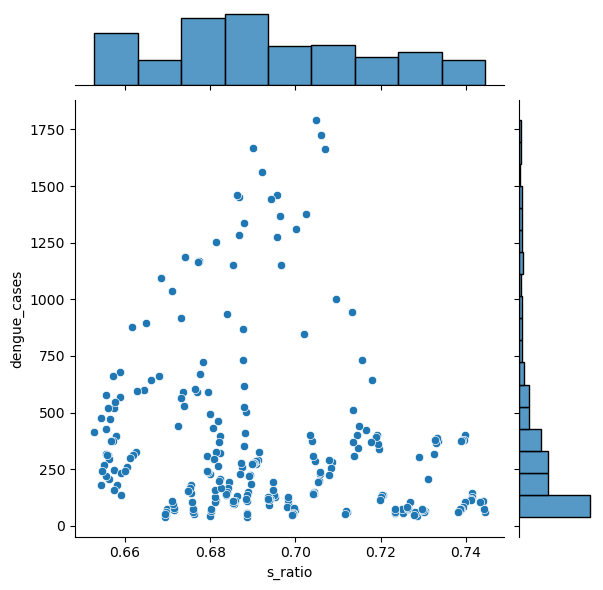

In [15]:
sns.jointplot(data=data[1:], x='s_ratio', y='dengue_cases');

#### Categorical Month Variables

In [16]:
data.index.month

Int64Index([4, 4, 4, 4, 5, 5, 5, 5, 6, 6,
            ...
            1, 1, 1, 1, 1, 2, 2, 2, 2, 3],
           dtype='int64', name='time', length=257)

In [17]:
# extract month from index as integer
data['month'] = data.index.month

# convert to categorical, dropping Jan
data = pd.concat([data.drop(columns='month'), pd.get_dummies(data['month'], prefix='month', drop_first=True)], axis=1)

### Data Export

In [18]:
# export full dataframe to csv
data.to_csv('../datasets/data_features_with_lags.csv', index=True)